## Setup 

load initial packages and df

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

# set seed
np.random.seed(2)

# read in data
df = pd.read_csv('cleaned_data.csv')

# list all column names without ...
pd.set_option('display.max_columns', None)

##### handle prepocessing #####
initial_dat = df

# Drop all rows with NA
initial_dat = initial_dat.dropna(subset=['Report Year','Total Persons Injured','Railroad Employees Injured','Passengers Injured','Others Injured'])

# Convert Report Year to int
initial_dat['Year'] = initial_dat['Report Year'].astype(int)
initial_dat = initial_dat.drop('Report Year', axis=1)

# Convert Date to Datetime
initial_dat = initial_dat.dropna(subset=['Date'])
initial_dat['date'] = pd.to_datetime(initial_dat['Date'])
initial_dat = initial_dat.drop('Date',axis=1)

# new time features based on datetime var/index
initial_dat['dayofweek'] = initial_dat['date'].dt.dayofweek.astype(int)
initial_dat['month'] = initial_dat['date'].dt.month.astype(int)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3258: DtypeWarning: Columns (20,32,33,41,42,43,44,45,46,47,48,49,50,105,106,111) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [16]:
initial_dat['Track Class'] = initial_dat['Track Class'].replace({0.0:0,
                                    1.0:'1',
                                    2.0:'2',
                                    3.0:'3',
                                    4.0:'4',
                                    5.0:'5',
                                    6.0:'6',
                                    'O':'0',
                                    '.':'0'})
initial_dat['Track Class'].value_counts()

1    115897
2     28818
4     24732
3     24408
5      4967
X      4202
6       731
7       180
8        72
0        24
9        13
0        10
Name: Track Class, dtype: int64

preprocessing for model

In [44]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer

#removing the year 2003 due to errors
initial_dat = initial_dat[initial_dat['Year'] != 2003]
print(initial_dat[initial_dat['Year'] == 2003])

initial_dat = initial_dat[initial_dat['Equipment Attended'] != '7']
initial_dat = initial_dat[initial_dat['Equipment Attended'] != '0']
initial_dat[initial_dat['Equipment Attended']=='7']
print(initial_dat['Equipment Attended'].value_counts())

cat_features = initial_dat[initial_dat['Year']>1999].loc[:,
        ['Reporting Railroad Name',
        'Accident Type',
        'Equipment Type',
        'Equipment Attended',
        'Method of Operation',
        'Passengers Transported',
        'Primary Accident Cause Code',
        'Accident Cause Code',
        'Track Class',
        'Reporting Railroad Class',
        'First Car Loaded',
        'Causing Car Loaded',
        'Time',
        'Visibility',
        'Weather Condition',
        'Maintenance Railroad Name']]

num_features = initial_dat[initial_dat['Year']>1999].select_dtypes(include=['float64', 'int64'])
num_features = num_features.drop(['Accident Year',
                   'Accident Month',
                   'Other Accident Year',
                   'Other Accident Month',
                   'Day',
                   'Maintenance Accident Year',
                   'Maintenance Accident Month',
                   'Railroad Employees Killed',
                   'Passengers Killed',
                   'Passengers Injured',
                   'Others Killed',
                   'Others Injured',
                   'Total Persons Killed',
                   'Total Persons Injured',
                   'Total Killed Form 54',
                   'Total Injured Form 54',
                   'Persons Killed For Reporting Railroad',
                   'Persons Injured For Reporting Railroad'], axis=1)


imputer = SimpleImputer(strategy='mean')
imputed = imputer.fit_transform(num_features)
oe_encoder = OrdinalEncoder()
oe = oe_encoder.fit_transform(cat_features)


#cat = pd.DataFrame.sparse.from_spmatrix(ohe, columns=ohe_encoder.get_feature_names_out())
num = pd.DataFrame(imputed, columns=imputer.feature_names_in_)
cat = pd.DataFrame(oe, columns=oe_encoder.feature_names_in_)

model_dat = pd.concat([num,cat],axis=1)

model_dat.fillna(-1, inplace=True)


Empty DataFrame
Columns: [Reporting Railroad Name, Accident Year, Accident Month, Other Railroad Name, Other Accident Number, Other Accident Year, Other Accident Month, Maintenance Railroad Name, Maintenance Accident Year, Maintenance Accident Month, Grade Crossing ID, Day, Time, Accident Type, Hazmat Cars, Hazmat Cars Damaged, Hazmat Released Cars, Persons Evacuated, Subdivision, Division, Station, Milepost, State Abbreviation, County Name, District, Temperature, Visibility, Weather Condition, Track Type, Track Name, Track Class, Track Density, Train Direction, Equipment Type, Equipment Attended, Train Speed, Recorded Estimated Speed, Maximum Speed, Gross Tonnage, Signalization, Method of Operation, Adjunct Code 1, Adjunct Code Name 1, Adjunct Code 2, Adjunct Code Name 2, Adjunct Code 3, Adjunct Code Name 3, Remote Control Locomotive, First Car Number, First Car Position, First Car Loaded, Causing Car Initials, Causing Car Number, Causing Car Position, Causing Car Loaded, Positive Alc

## Creating Model

### Split Data (Training/Testing)

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import mean_absolute_error

X = model_dat.drop('Railroad Employees Injured',axis=1)
y = model_dat['Railroad Employees Injured']
xtrain, xtest, ytrain, ytest = train_test_split(X,y, test_size=.4)

print("X-train shape: ", xtrain.shape)
print("Y-train shape: ", ytrain.shape)
print("X-test shape: ", xtest.shape)
print("Y-test shape: ", ytest.shape)


X-train shape:  (40276, 67)
Y-train shape:  (40276,)
X-test shape:  (26852, 67)
Y-test shape:  (26852,)


### Build and Fit RF Model

In [49]:
rfreg = RandomForestRegressor(max_features='sqrt',
                              n_estimators=50,
                              n_jobs=-1,
                              random_state=0)

rfreg.fit(xtrain, ytrain)
rf_score = rfreg.score(xtest,ytest)
rf_pred = rfreg.predict(xtest)
rf_mae = mean_absolute_error(ytest,rf_pred)

print("score:",rf_score)
print("MAE:",rf_mae)

score: 0.3571078272431315
MAE: 0.07083345747057948


#### Analyze Model

feature importances

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


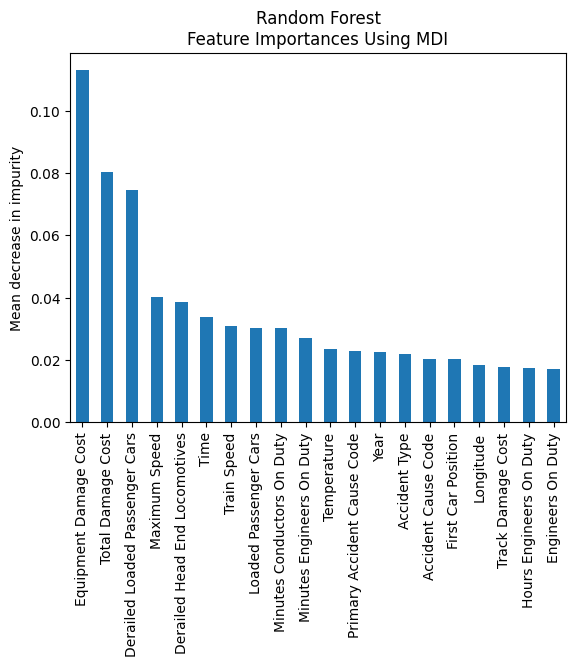

In [65]:
importances = rfreg.feature_importances_
colnames = X.columns

std = np.std([tree.feature_importances_ for tree in rfreg.estimators_], axis=0)
forest_importances = pd.DataFrame({'importances':importances,'std':std}, index=colnames)
forest_importances.sort_values('importances',ascending=False)

top_20 = forest_importances.sort_values('importances',ascending=False).iloc[0:20,0]
std = forest_importances.sort_values('importances',ascending=False).iloc[0:20,1]
fig, ax = plt.subplots()
top_20.plot.bar(ax=ax)
ax.set_title("Random Forest\nFeature Importances Using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.savefig("images/rf-injury-feature-importance.png")
fig.show()

predictions visualized

In [51]:
pred_data = pd.concat([model_dat['Year'].astype(int),pd.Series(ytest),pd.Series(rf_pred)],axis=1)
pred_data['prediction'] = pred_data.iloc[:,2]
pred_data['injuries'] = pred_data.iloc[:,1]
pred_data = pd.DataFrame(pred_data.iloc[:,[0,3,4]])

inj_yr = pred_data.groupby('Year')['injuries'].sum().reset_index()
pred_yr = pred_data.groupby('Year')['prediction'].sum().reset_index()

In [53]:
pd.concat([inj_yr,pred_yr],axis=1)

,Year,injuries,Year,prediction
0,2000,93.0,2000,25.62
1,2001,103.0,2001,37.00
2,2002,82.0,2002,192.50
3,2004,93.0,2004,0.00
4,2005,79.0,2005,24.82
5,2006,64.0,2006,42.08
6,2007,52.0,2007,45.34
7,2008,58.0,2008,31.80
8,2009,39.0,2009,8.64
9,2010,52.0,2010,88.80


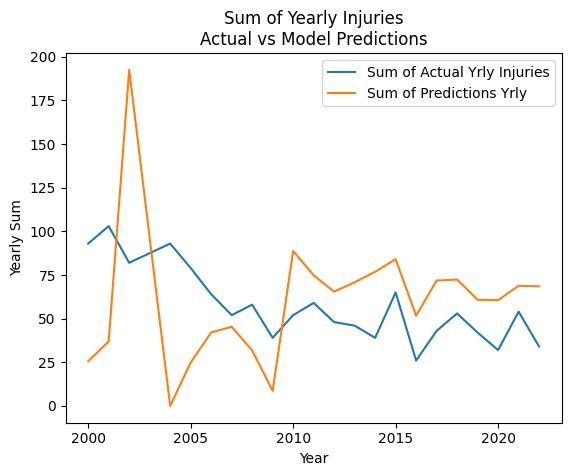

In [66]:
plt.plot('Year','injuries', data=inj_yr, label='Sum of Actual Yrly Injuries')
plt.plot('Year','prediction', data=pred_yr, label='Sum of Predictions Yrly')
plt.xlabel('Year')
plt.ylabel('Yearly Sum')
plt.title('Sum of Yearly Injuries\nActual vs Model Predictions')
plt.legend()
plt.savefig("images/rf-pred-vs-actual.png")
plt.show()

### Use Cross Validation

In [59]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

cv = cross_validate(rfreg,X,y,cv=5,return_train_score=True,n_jobs=-1)
cv_pred = cross_val_predict(rfreg,X,y,cv=5, n_jobs=-1)

In [60]:
cv.keys()
cv['test_score']

array([0.26884136, 0.39076049, 0.38094683, 0.31616526, 0.39028742])

In [61]:
cv_pred_data = pd.concat([model_dat['Year'].astype(int),pd.Series(y),pd.Series(cv_pred)],axis=1)
cv_pred_data['prediction'] = cv_pred_data.iloc[:,2]
cv_pred_data['injuries'] = cv_pred_data.iloc[:,1]
cv_pred_data = pd.DataFrame(cv_pred_data.iloc[:,[0,3,4]])

cv_inj_yr = cv_pred_data.groupby('Year')['injuries'].sum().reset_index()
cv_pred_yr = cv_pred_data.groupby('Year')['prediction'].sum().reset_index()

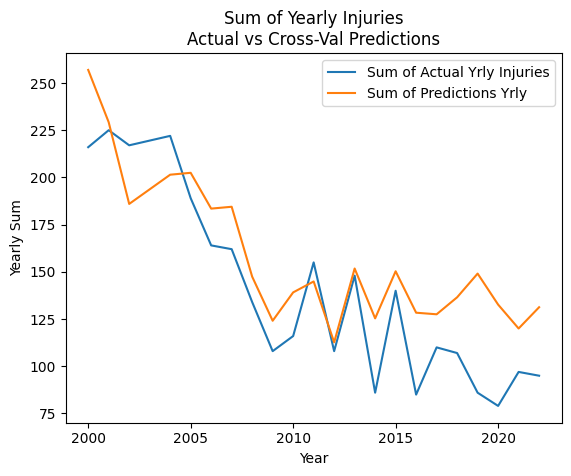

In [67]:
plt.plot('Year','injuries', data=cv_inj_yr, label='Sum of Actual Yrly Injuries')
plt.plot('Year','prediction', data=cv_pred_yr, label='Sum of Predictions Yrly')
plt.xlabel('Year')
plt.ylabel('Yearly Sum')
plt.title('Sum of Yearly Injuries\nActual vs Cross-Val Predictions')
plt.legend()
plt.savefig("images/cv-pred-vs-actual.png")
plt.show()